In [11]:
#importing required modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#initializing basic variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
batch_size = 32
lr = 0.0002
epochs = 20
image_size = 28*28

In [3]:
#data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataloader = DataLoader(
    datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.67MB/s]


In [4]:
#defining generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),     #GAN papers show that LeakyReLU function better
            nn.Linear(512, image_size),
            nn.Tanh()              #tanh scales output to [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

In [5]:
#defining discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()            #sigmoid gives output in range [0, 1]
        )

    def forward(self, img):
        return self.model(img)

In [7]:
G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss() #binary cross entropy loss function

optimizer_G = optim.Adam(G.parameters(), lr=lr)
optimizer_D = optim.Adam(D.parameters(), lr=lr)

Epoch [1/20]  D_loss: 0.1915  G_loss: 3.8364


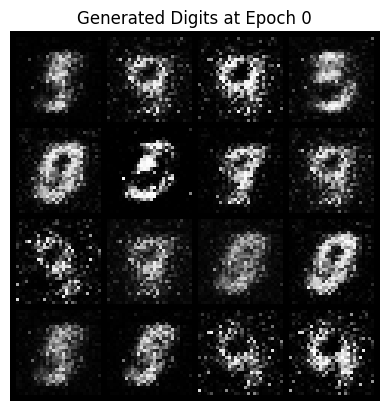

Epoch [2/20]  D_loss: 0.4239  G_loss: 3.0608
Epoch [3/20]  D_loss: 0.3552  G_loss: 2.3151
Epoch [4/20]  D_loss: 0.4872  G_loss: 4.1491
Epoch [5/20]  D_loss: 0.5505  G_loss: 2.9521
Epoch [6/20]  D_loss: 0.5310  G_loss: 2.4372
Epoch [7/20]  D_loss: 0.4938  G_loss: 3.3157
Epoch [8/20]  D_loss: 1.0658  G_loss: 2.1159
Epoch [9/20]  D_loss: 0.5961  G_loss: 2.6822
Epoch [10/20]  D_loss: 0.7747  G_loss: 1.8449
Epoch [11/20]  D_loss: 0.8838  G_loss: 1.5531


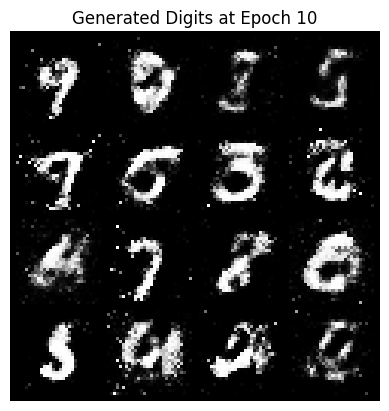

Epoch [12/20]  D_loss: 0.6938  G_loss: 1.9132
Epoch [13/20]  D_loss: 0.7059  G_loss: 2.0816
Epoch [14/20]  D_loss: 1.0972  G_loss: 2.2484
Epoch [15/20]  D_loss: 0.9256  G_loss: 1.6069
Epoch [16/20]  D_loss: 0.7419  G_loss: 2.0312
Epoch [17/20]  D_loss: 0.9635  G_loss: 1.3961
Epoch [18/20]  D_loss: 0.7665  G_loss: 1.9574
Epoch [19/20]  D_loss: 0.8263  G_loss: 1.8229
Epoch [20/20]  D_loss: 0.8703  G_loss: 1.8519


In [12]:
for epoch in range(epochs):

    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.view(-1, image_size).to(device)
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)

        z = torch.randn(imgs.size(0), latent_dim).to(device)
        generated_imgs = G(z)
        G_loss = criterion(D(generated_imgs), real_labels)

        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

        real_loss = criterion(D(real_imgs), real_labels)
        fake_loss = criterion(D(generated_imgs.detach()), fake_labels)
        D_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {D_loss.item():.4f}  G_loss: {G_loss.item():.4f}")

    if epoch % 10 == 0:
        with torch.no_grad():
            test_z = torch.randn(16, latent_dim).to(device)
            generated = G(test_z).view(-1, 1, 28, 28)
            grid_img = np.transpose(torchvision.utils.make_grid(generated, nrow=4, normalize=True).cpu(), (1, 2, 0))
            plt.imshow(grid_img)
            plt.title(f'Generated Digits at Epoch {epoch}')
            plt.axis('off')
            plt.show()